In [1]:
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import argparse
import pickle
import pandas as pd
import os
from utils import *
from data_builder import *
from utils import *
from model_builder import get_models
import matplotlib.ticker as mtick
# sns.set_context("poster")

%matplotlib inline


/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Define some utility functions

In [2]:
def hamiltonian_fn(coords,typev=1):
    if DSET_NAME == 'spring_coupled':
        m = 2
        k = 3
        q1 =coords[:,0]
        q2 = coords[:,1]
        p1 = coords[:,2]
        p2 = coords[:,3]
        K= (p1**2)/(2*m) + (p2**2)/(2*m) 
        U = k*q1**2 +k*q2**2 - k*q1*q2
        
    
    if DSET_NAME == 'duffing':
        q, p = coords[:,0],coords[:,1]
        alpha = -1
        beta = 1
        omega = 1.2
        delta = 0.3
        gamma = .2
        K=(p ** 2) / 2
        U = alpha * (q ** 2) / 2  + beta * (q ** 4) / 4 

    elif DSET_NAME == 'relativity':
        q, p = coords[:,0],coords[:,1]
        c =1
        m = 1
        g = 9.81

        omega = 1.2
        delta = 0
        gamma = 0.2
        alpha = 1
        beta = 1


        K = c * np.sqrt(p ** 2 + m ** 2 * c ** 2) 
        U= alpha * (q ** 2) / 2 + beta * (q ** 4) / 4
        
    else:
        q, p = coords[:,0],coords[:,1]
        K = (p ** 2) / 2 
        U = (q ** 2) / 2  
        t = np.arange(0,T_max_t,dt)[:1]
        K = (p ** 2) / 2 
        U = (q ** 2) / 2  
    if typev == 1:
        return K,U
    else:
        return K+U#-q*sin(3*t)
    
    
    
def hamiltonian_fn2(coords,typev=1):
    
    if DSET_NAME == 'spring_coupled':
        m = 2
        k = 3
        q1 =coords[:,0]
        q2 = coords[:,1]
        p1 = coords[:,2]
        p2 = coords[:,3]
        K= (p1**2)/(2*m) + (p2**2)/(2*m) 
        U = k*q1**2 +k*q2**2 - k*q1*q2
     
    
    if DSET_NAME == 'duffing':
        q, p = coords[:,0],coords[:,1]
        alpha = -1
        beta = 1
        omega = 1.2
        delta = 0.3
        gamma = .2
        K=(p ** 2) / 2
        U = alpha * (q ** 2) / 2  + beta * (q ** 4) / 4 

    elif DSET_NAME == 'relativity':
        q, p = coords[:,0],coords[:,1]
        c =1
        m = 1
        g = 9.81

        omega = 1.2
        delta = 0
        gamma = 0.2
        alpha = 1
        beta = 1


        K = c * torch.sqrt(p ** 2 + m ** 2 * c ** 2) 
        U= alpha * (q ** 2) / 2 + beta * (q ** 4) / 4
        
    else:
        q, p = coords[:,0],coords[:,1]
        K = (p ** 2) / 2 
        U = (q ** 2) / 2  
        t = np.arange(0,T_max_t,dt)[:1]
        K = (p ** 2) / 2 
        U = (q ** 2) / 2  
    if typev == 1:
        return K,U
    else:
        return K+U

In [3]:
def plot_state_energy_loss(new_df,noisv):
    
    sns.axes_style(style='ticks')
    sns.set_context("paper",font_scale=3, rc={'lines.linewidth':3})
    sns.set_palette('deep')
    
    fig,ax = plt.subplots(1,2,figsize=(20,7))

    g = sns.barplot(x='Method',y='State Error',data=new_df,ax=ax[0])
    g.set_yscale('log')

    g = sns.barplot(x='Method',y='Energy Error',data=new_df,ax=ax[1])
    g.set_yscale('log')

    ax[1].set_ylabel('Average Energy MSE')
    ax[0].set_ylabel('Average State MSE')

    plt.tight_layout()
    plt.savefig(path_dir+f'/{dataset_name}_errors_{noisv}.pdf',format='pdf',dpi=2400)


In [4]:
def plot_single_state_rollout(main_pred,noisv):

    sns.axes_style(style='ticks')
    sns.set_context("paper",font_scale=2., rc={"font.size":25,"axes.titlesize":25,"axes.labelsize":25,'lines.linewidth':3})
    sns.set_palette('deep')
    
    lab_list = list(main_pred.keys())
    fig,axs = plt.subplots(2,2,figsize=(10,10))
    ax = axs.ravel()
    #ax = axs.ravel()
    # lab_list.remove('TDHNN')
    # lab_list.remove('TDHNN1')
    for dex,name in enumerate(lab_list):
        yhat = main_pred[name][-9][0]
        true_batch = main_pred[name][-9][1]
#         print(yhat,true_batch)
        K_pred,U_pred = hamiltonian_fn(yhat,1)
        K_true,U_true = hamiltonian_fn(true_batch,1)
        ham_pred = K_pred + U_pred
        ham_true = K_true + U_true

        ax[0].set_title('State Rollout')
        sns.lineplot(x=yhat[::,0],y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    #     sns.lineplot(x=range(len(yhat[::,0])),y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)

        ax[0].set_xlabel(r'$q$')
        ax[0].set_ylabel(r'$p$')


        ax[1].set_title('Energy Rollout')
        sns.lineplot(x=np.arange(len(ham_pred))*dt,y=ham_pred,label=lab_list[dex],ax=ax[1],legend=False)
        ax[1].set_xlabel('Time (s)')
        ax[1].set_ylabel('Energy')



        ax[2].set_title('State MSE')
        l1 =sns.lineplot(x=np.arange(len(yhat))*dt,y=((yhat-true_batch)**2).mean(1),label=lab_list[dex],ax=ax[2],legend=False)
        ax[2].set_xlabel('Time (s)')
        ax[2].set_ylabel('MSE')

        ax[3].set_title('Energy MSE')
        l2 =sns.lineplot(x=np.arange(len(yhat))*dt,y=(ham_pred-ham_true)**2,label=lab_list[dex],ax=ax[3],legend=False)
        ax[3].set_xlabel('Time (s)')
        ax[3].set_ylabel('MSE')

    sns.lineplot(x=true_batch[:,0],y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
    sns.lineplot(x=np.arange(len(ham_pred))*dt,y=ham_true,label='Ground Truth',ax=ax[1],legend=False)
    sns.lineplot(x=np.arange(len(yhat))*dt,y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[2],legend=False)
    sns.lineplot(x=np.arange(len(yhat))*dt,y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[3],legend=False)
#     ax[1].ticklabel_format(axis="y", style="sci")


    ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax[1].set_yscale('log')
    ax[2].set_yscale('log')
    ax[3].set_yscale('log')

    handles, labels = ax[3].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.52, -0.015),fancybox=True,ncol=6)
    plt.tight_layout()
    plt.savefig(path_dir+f'/{dataset_name}_long_{noisv}.pdf',dpi=2400,bbox_inches='tight')


In [5]:
def plot_hamiltonian(noisv):
    
    sns.axes_style(style='ticks')
    sns.set_context("paper",font_scale=2.4, rc={"font.size":30,"axes.titlesize":25,"axes.labelsize":25,'lines.linewidth':3})
    sns.set_palette('deep')
    
    
    q = torch.arange(-3,3,0.1)
    qd = torch.arange(-3,3,0.1)
    q= q.float()
    qd = qd.float()
    q.requires_grad = True
    qd.requires_grad = True
    qm,qdm = torch.meshgrid(q,qd)

    main_pred = {'HNN':[],'TDHNN':[],'pHNN':[]}
    new_model_nms = list(main_pred.keys())
    fig,axs = plt.subplots(1,len(model_nms),figsize=(5*len(model_nms),5))
    ax = axs.ravel()
    for i,model_name in enumerate(new_model_nms):
        ax[i].set_xlabel(r'$q$')
        ax[i].set_ylabel(r'$p$')
        if model_name == 'pHNN':
            model_type = torch.load(f'{dataset_name}_{type_vec}/TDHNN4/noise_{noisv}/model',map_location='cpu')
        else:
            model_type = torch.load(f'{dataset_name}_{type_vec}/{model_name}/noise_{noisv}/model',map_location='cpu')
        model_type.eval()
        if model_type.mlp1.in_features == 3:
            f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1),torch.zeros(*qm.shape).reshape(-1,1)],1))
            print(f.shape)
        else:
            f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1))
#         if i == 0:
#             cs = ax[i].contour(qm.detach().numpy(),qdm.detach().numpy(),f.reshape(-1,qm.shape[0]).detach().numpy(),levels=20)
        ax[i].contour(qm.detach().numpy(),qdm.detach().numpy(),f.reshape(-1,qm.shape[0]).detach().numpy(),levels=20)
        ax[i].set_title(model_name)
     
    ftrue = hamiltonian_fn2(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1),2)
    ax[-1].contour(qm.detach().numpy(),qdm.detach().numpy(),ftrue.reshape(-1,qm.shape[0]).detach().numpy(),levels=20)
    ax[-1].set_title('Ground Truth')
    ax[-1].set_xlabel(r'$q$')
    ax[-1].set_ylabel(r'$p$')
    plt.tight_layout()
    plt.savefig(path_dir+f'/{dataset_name}_hamiltonian_{noisv}.pdf',dpi=2400,bbox_inches='tight')


In [58]:
def plot_force_and_damping_1(model_type,noisv):
    sns.axes_style(style='ticks')
    sns.set_context("paper",font_scale=2.4, rc={"font.size":30,"axes.titlesize":25,"axes.labelsize":30,'lines.linewidth':3})
    sns.set_palette('deep')
    
    fig,ax = plt.subplots(1,2,figsize=(18,10))
    axs = ax.ravel()
    for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
        q=q.to(device)
        q=q.float()
        q.requires_grad=True
        tevals.to(device)
        tevals.requires_grad = True
        tevals = tevals.float()
        d = model_type.get_D()
        f = model_type.get_F(tevals.reshape(-1,1))
        print(f.shape)
        print(d.shape)
        
        H0 = model_type.get_H(q)
        dH0 = torch.autograd.grad(H0.sum(), q, create_graph=True)[0]
        derivs = dH0 @ model_type.M.t()
        qdot = derivs[:,0].reshape(-1,1)
        
        minlim = np.min([f.detach().numpy(),(d[0]*qdot).detach().numpy()])
        suplim = np.max([f.detach().numpy(),(d[0]*qdot).detach().numpy()])
    
        if DSET_NAME == 'spring_coupled':
            axs[0].plot(np.arange(len(tevals))*dt,-(f[:,0]).detach().numpy(),c='royalblue',label=r'predicted $F(t)$ p1' )
            axs[1].plot(np.arange(len(tevals))*dt,(d[0,0]*qdot).detach().numpy(),c='firebrick',label=r'predicted $\nu \frac{d \mathcal{H}}{dp}$ p1')
            axs[0].plot(np.arange(len(tevals))*dt,-(f[:,1]).detach().numpy(),c='royalblue',label=r'predicted $F(t)$ p2' )
            axs[1].plot(np.arange(len(tevals))*dt,(d[0,1]*qdot).detach().numpy(),c='firebrick',label=r'predicted $\nu \frac{d \mathcal{H}}{dp}$ p2')
        
        else:
            axs[0].plot(np.arange(len(tevals))*dt,-(f).detach().numpy(),c='royalblue',label=r'predicted $F(t)$' )
            axs[1].plot(np.arange(len(tevals))*dt,(d[0]*qdot).detach().numpy(),c='firebrick',label=r'predicted $\nu \frac{d \mathcal{H}}{dp}$')
        
        if DSET_NAME == 'mass_spring':
            axs[0].scatter(np.arange(len(tevals))[::10]*dt,-0*np.sin(3*tevals.detach().numpy()[::10])*np.sin(6*tevals.detach().numpy()[::10]),label='ground truth force',c='black',marker='x')
            axs[1].scatter(np.arange(len(q))[::20]*dt,(-0.*q[::20,1]).detach().numpy(),label='ground truth damping',c='black',marker='o',s=50)
        elif DSET_NAME == 'damped':
            axs[0].scatter(np.arange(len(tevals))[::10]*dt,-0*np.sin(3*tevals.detach().numpy()[::10])*np.sin(6*tevals.detach().numpy()[::10]),label='ground truth force',c='black',marker='x')
            axs[1].scatter(np.arange(len(q))[::20]*dt,(-0.3*q[::20,1]).detach().numpy(),label='ground truth damping',c='black',marker='o',s=50)
        elif DSET_NAME == 'forced_mass_spring':
            if type_vec == 1:
                axs[0].scatter(np.arange(len(tevals))[::10]*dt,-1*np.sin(3*tevals.detach().numpy()[::10]),label='ground truth force',c='black',marker='x')
                axs[1].scatter(np.arange(len(q))[::20]*dt,(-0.*q[::20,1]).detach().numpy(),label='ground truth damping',c='black',marker='o',s=50)
            elif type_vec == 2:
                axs[0].scatter(np.arange(len(tevals))[::10]*dt,-1*np.sin(3*tevals.detach().numpy()[::10])*np.sin(6*tevals.detach().numpy()[::10]),label='ground truth force',c='black',marker='x')
                axs[1].scatter(np.arange(len(q))[::20]*dt,(-0.*q[::20,1]).detach().numpy(),label='ground truth damping',c='black',marker='o',s=50)
        elif DSET_NAME == 'duffing':
            axs[0].scatter(np.arange(len(tevals))[::10]*dt,-0.2*np.sin(1.2*tevals.detach().numpy()[::10]),label='ground truth force',c='black',marker='x')
            axs[1].scatter(np.arange(len(q))[::20]*dt,(-0.3*q[::20,1]).detach().numpy(),label='ground truth damping',c='black',marker='o',s=50)
        elif DSET_NAME == 'relativity':
            axs[0].scatter(np.arange(len(tevals))[::10]*dt,-0.2*np.sin(1.2*tevals.detach().numpy()[::10]),label='ground truth force',c='black',marker='x')
            axs[1].scatter(np.arange(len(q))[::20]*dt,(-0*q[::20,1]).detach().numpy(),label='ground truth damping',c='black',marker='o',s=50)
        elif DSET_NAME == 'spring_coupled':
            axs[0].scatter(np.arange(len(tevals))[::10]*dt,-np.cos(tevals.detach().numpy()[::10]) -0.2,label='ground truth force p1',c='black',marker='x')
            axs[0].scatter(np.arange(len(tevals))[::10]*dt,0*np.cos(tevals.detach().numpy()[::10]),label='ground truth force p2',c='black',marker='x')
            
            axs[1].scatter(np.arange(len(q))[::20]*dt,(-0*q[::20,1]).detach().numpy(),label='ground truth damping p1',c='black',marker='o',s=50)
            axs[1].scatter(np.arange(len(q))[::20]*dt,(-0*q[::20,1]).detach().numpy(),label='ground truth damping p2',c='black',marker='o',s=50)

            
#         elif DSET_NAME == 'spring_coupled':
#             axs[0].scatter(np.arange(len(tevals))[::10]*dt,-0.2*np.sin(1.2*tevals.detach().numpy()[::10]),label='ground truth force',c='black',marker='x')
#             axs[1].scatter(np.arange(len(q))[::20]*dt,(-0*q[::20,1]).detach().numpy(),label='ground truth damping',c='black',marker='o',s=50)
            
        
        axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

        axs[0].legend(loc='best')
        axs[1].legend(loc='best')
        axs[0].set_xlabel('Time (s)')
        axs[1].set_xlabel('Time (s)')
        axs[0].set_ylabel(r'$F(t)$')
        axs[1].set_ylabel(r'$\nu \frac{d\mathcal{H}}{dp}$')
        break
    plt.tight_layout()
    plt.savefig(path_dir+f'/{dataset_name}_dpdt_new_{noisv}.pdf',dpi=2400,bbox_inches='tight')

#### Data Generation

specify one of the systems (configurations are currently set to defaults for training):

- mass_spring
- duffing
- damped
- forced_mass_spring (1 or 2)
- relativistic

In [46]:
DSET_NAME = 'spring_coupled'
n_test_traj = 25
noisy = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if DSET_NAME == 'mass_spring':
    T_max_t = 3.05
    dt = 0.05
    type_vec = 1
    
elif DSET_NAME == 'spring_coupled':
    T_max_t = 5.1
    dt = 0.1
    type_vec = 1

elif DSET_NAME == 'damped':
    T_max_t = 30.1
    dt = 0.1
    type_vec = 1


elif DSET_NAME == 'forced_mass_spring':
    T_max_t = 10.01
    dt = 0.01
    type_vec = 2
    
elif DSET_NAME == 'duffing':
    T_max_t = 10.01
    dt = 0.01
    type_vec = 1
    
elif DSET_NAME == 'relativity':
    T_max_t = 10.01
    dt = 0.01
    type_vec = 1

    
num_samples_per_traj = int(np.ceil((T_max_t / dt))) - 1    
dataset_name = DSET_NAME


In [47]:

# dataset preprocessing
valid_data = get_dataset(dataset_name, n_test_traj, T_max_t, dt, noise_std=0, seed=3,typev=type_vec)
BS = num_samples_per_traj

vnow, vnext, venergy, vdx, vevals = nownext(valid_data, n_test_traj, T_max_t, dt, dt)


valdat = pendpixdata(vnow, vnext, venergy, vdx, vevals)
val_dataloader = DataLoader(valdat, batch_size=BS, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = { 'valid': []}

path_dir = f'figures/{dataset_name}/{type_vec}'
if not os.path.exists(path_dir):
    os.makedirs(path_dir)
    
def integrate_model(model, t_span, y0,t_eval, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,len(np_x))
        t = torch.tensor( t, requires_grad=True, dtype=torch.float32).view(1,1) 
        dx = model.time_deriv(x,t).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0,t_eval=t_eval, **kwargs)

def test_model(model_name,model):
    # Each epoch has a training and validation phase
    for phase in ['valid']:
        for batch_i, (q, q_next, _, qdx, tevals) in enumerate(data_dict[phase]):
            q, q_next, qdx = q.float(), q_next.float(), qdx.float()
            q.to(device)
            q_next.to(device)
            qdx.to(device)
            tevals = tevals.float()
            tevals.to(device)
            loss = 0
            q.requires_grad = True
            tevals.requires_grad = True

            qinit = q[0].reshape(1, -1)

            preds = integrate_model(model,[0,T_max_t],qinit.detach().numpy().ravel(),t_eval=np.arange(0,T_max_t,dt)).y

            main_pred[model_name].append(((preds.T)[:-1],q.detach().numpy()))




[ 0.0507979   0.20814782 -0.16727621  0.00866208]
(4, 51)
[-0.32748175  0.32843192 -0.36634438  0.29356295]
(4, 51)
[ 0.26260242  0.15966394  0.23538736 -0.28083495]
(4, 51)
[ 0.01585747 -0.4786489   0.25637239  0.15083316]
(4, 51)
[0.44903536 0.10774676 0.31528961 0.09441089]
(4, 51)
[ 0.37133431 -0.49424838 -0.27838489 -0.24483142]
(4, 51)
[-0.06482381 -0.24226514  0.01727814  0.23957717]
(4, 51)
[-0.32949184  0.06530304 -0.19771112  0.09518973]
(4, 51)
[ 0.13413039 -0.19208316  0.05070366  0.07784453]
(4, 51)
[ 0.37383811 -0.11685684 -0.3031618  -0.38571455]
(4, 51)
[-0.16991349  0.49310954  0.01717831 -0.33449489]
(4, 51)
[-0.06529235 -0.32090667  0.19921605 -0.14635428]
(4, 51)
[-0.22611697 -0.15665568  0.11685472  0.1589938 ]
(4, 51)
[-0.23038619  0.16332445 -0.13638169 -0.35270565]
(4, 51)
[-0.02421441  0.25255229  0.09914026  0.33781541]
(4, 51)
[-0.2819976   0.13683921 -0.17491723  0.18307366]
(4, 51)
[-0.40019646 -0.49467366  0.32834008 -0.09611419]
(4, 51)
[-0.20664366  0.26

specify noise variable used in training

torch.Size([50, 2])
torch.Size([1, 2])


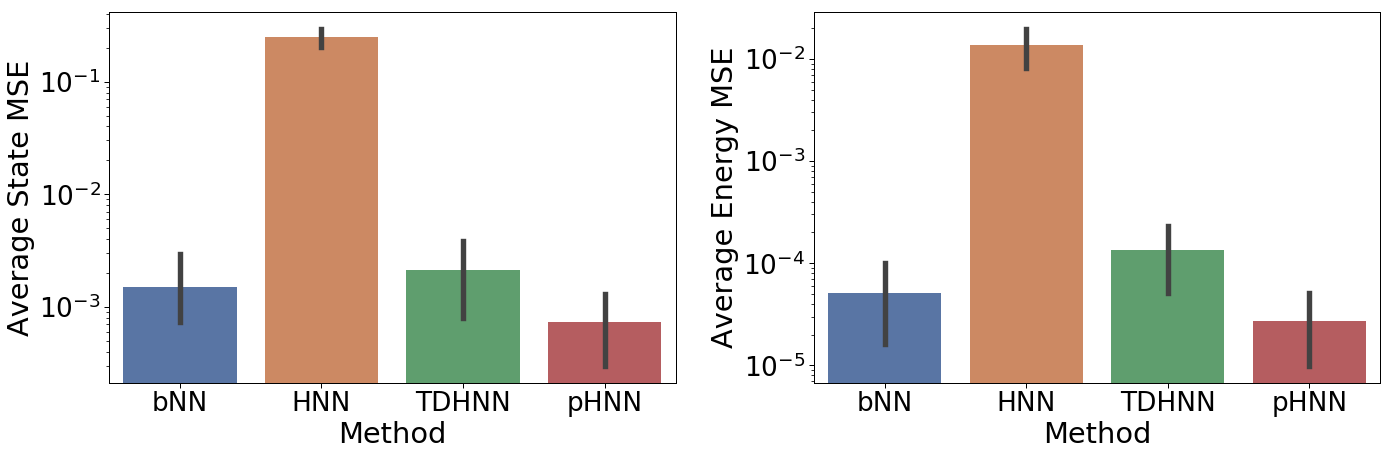

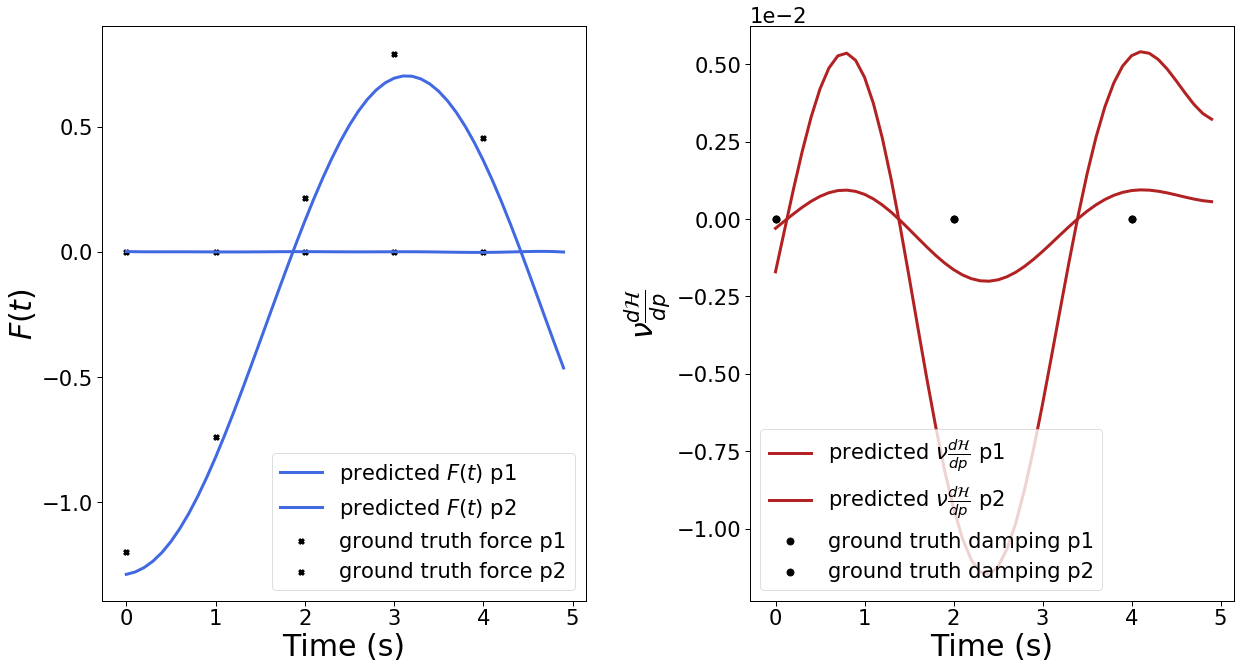

In [59]:
noise_vec = [0]

df_noisy = pd.DataFrame(columns=['bNN','HNN','TDHNN','pHNN'])
for noisv in noise_vec:
    
    main_pred = {'bNN':[],'HNN':[],'TDHNN':[],'pHNN':[]}
    model_nms = list(main_pred.keys())
    for model_name in model_nms:
        if model_name == 'pHNN':
            model_type = torch.load(f'{dataset_name}_{type_vec}/TDHNN4/noise_{noisv}/model',map_location='cpu')
        elif model_name == 'bNN':
            model_type = torch.load(f'{dataset_name}_{type_vec}/baseline/noise_{noisv}/model',map_location='cpu')
        else:
            model_type = torch.load(f'{dataset_name}_{type_vec}/{model_name}/noise_{noisv}/model',map_location='cpu')
        model_type.eval()
        test_model(model_name,model_type)
    new_df = pd.DataFrame(columns=['Method','State Error','Energy Error'])
    for model in model_nms:
        vals = main_pred[model]
        for i in range(len(vals)):
            pred = vals[i][0]
            true = vals[i][1]
            state_error = np.mean(np.square(pred-true))
            energy_error = np.mean(np.square(hamiltonian_fn(pred,2)-hamiltonian_fn(true,2)))
            new_df.loc[len(new_df)] = [model,state_error,energy_error]
    df_noisy.loc[len(df_noisy)] = new_df.groupby('Method')['State Error'].mean()
    df_noisy.loc[len(df_noisy)] = new_df.groupby('Method')['State Error'].std()
    
    df_noisy.loc[len(df_noisy)] = new_df.groupby('Method')['Energy Error'].mean()
    df_noisy.loc[len(df_noisy)] = new_df.groupby('Method')['Energy Error'].std()
    
    plot_state_energy_loss(new_df,noisv)
#     plot_single_state_rollout(main_pred,noisv)
#     plot_hamiltonian(noisv)
    plot_force_and_damping_1(model_type,noisv)

In [38]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(df_noisy)

       bNN    HNN    TDHNN     pHNN
0  0.00151  0.248   0.0021 0.000734
1  0.00324  0.119  0.00379  0.00134
2 5.08e-05 0.0136 0.000134 2.72e-05
3 0.000118 0.0155  0.00025 5.59e-05


In [10]:
model_name = 'TDHNN'
model_type = torch.load(f'{dataset_name}_{type_vec}/{model_name}/noise_{noisv}/model',map_location='cpu')
model_type.eval()

TDHNN(
  (mlp1): Linear(in_features=3, out_features=200, bias=True)
  (mlp2): Linear(in_features=200, out_features=200, bias=True)
  (mlp3): Linear(in_features=200, out_features=200, bias=True)
  (mlp4): Linear(in_features=200, out_features=1, bias=False)
)

In [15]:
for batch_i, (q, q_next, _, qdx, tevals) in enumerate(data_dict['valid']):
    if batch_i == 0:
        q, q_next, qdx = q.float(), q_next.float(), qdx.float()
        q.to(device)
        q_next.to(device)
        qdx.to(device)
        tevals = tevals.float()
        tevals.to(device)
        loss = 0
        q.requires_grad = True
        tevals.requires_grad = True

        qinit = q[0].reshape(1, -1)
        x = qinit
        t = tevals[0]
        input_vec = torch.cat([x,t.reshape(-1,1)],1)
        H = model_type.get_H(input_vec)
        dF2 = torch.autograd.grad(H.sum(), x, create_graph=True)[0]
        print(dF2@model_type.M.t())
        
        
        x = qinit
        t = tevals[0]
        input_vec = torch.cat([x,t.reshape(-1,1)],1)
        H = model_type.get_H(input_vec)
        dF2 = torch.autograd.grad(H.sum(), input_vec, create_graph=True,allow_unused=True)[0]
        print(dF2[:,:(input_vec.shape[1]-1)]@model_type.M.t())




tensor([[ 1.3303, -0.0345]], grad_fn=<MmBackward>)
tensor([[ 1.3303, -0.0345]], grad_fn=<MmBackward>)


In [ ]:

model_type.get_H

In [18]:
vals[0][0].shape

(50, 4)

In [11]:
df_noisy

,bNN,HNN,TDHNN,pHNN
0,0.001512,0.247738,0.002103,0.000734
1,0.000051,0.013626,0.000134,0.000027


In [14]:
sdf = np.zeros(5)

In [16]:
sdf[66]

IndexError: index 66 is out of bounds for axis 0 with size 5